Day 77: Movie Theater Data (Linear Regression with sklearn and seaborn)

# Introduction

Do higher film budgets lead to more box office revenue? Let's find out if there's a relationship using the movie budgets and financial performance data that I've scraped from [the-numbers.com](https://www.the-numbers.com/movie/budgets) on **May 1st, 2018**. 

<img src=https://i.imgur.com/kq7hrEh.png>

# Import Statements

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Notebook Presentation

In [108]:
pd.options.display.float_format = '{:,.2f}'.format

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Read the Data

In [109]:
data = pd.read_csv('cost_revenue_dirty.csv')

# Explore and Clean the Data

**Challenge**: Answer these questions about the dataset:
1. How many rows and columns does the dataset contain?
2. Are there any NaN values present?
3. Are there any duplicate rows?
4. What are the data types of the columns?

In [110]:
data.shape

(5391, 6)

In [111]:
data.isna().values.any()

False

In [112]:
data_dedupe = data.drop_duplicates()
data_dedupe.shape == data.shape

True

In [113]:
for col in data.columns:
    first_entry = data[col][0]
    print(type(first_entry))

<class 'numpy.int64'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Rank                   5391 non-null   int64 
 1   Release_Date           5391 non-null   object
 2   Movie_Title            5391 non-null   object
 3   USD_Production_Budget  5391 non-null   object
 4   USD_Worldwide_Gross    5391 non-null   object
 5   USD_Domestic_Gross     5391 non-null   object
dtypes: int64(1), object(5)
memory usage: 252.8+ KB


### Data Type Conversions

**Challenge**: Convert the `USD_Production_Budget`, `USD_Worldwide_Gross`, and `USD_Domestic_Gross` columns to a numeric format by removing `$` signs and `,`.

Note that *domestic* in this context refers to the United States.

In [115]:
for col in ['USD_Production_Budget', 'USD_Worldwide_Gross', 'USD_Domestic_Gross']:
    data[col] = data[col].astype(str).str.replace(',', '')
    data[col] = data[col].astype(str).str.replace('$', '')
    data[col] = pd.to_numeric(data[col])

/Users/mymac/PycharmProjects/100DaysOfCode/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


**Challenge**: Convert the `Release_Date` column to a Pandas Datetime type. 

In [116]:
data['Release_Date'] = pd.to_datetime(data['Release_Date'])

### Descriptive Statistics

**Challenge**: 

1. What is the average production budget of the films in the data set?
2. What is the average worldwide gross revenue of films?
3. What were the minimums for worldwide and domestic revenue?
4. Are the bottom 25% of films actually profitable or do they lose money?
5. What are the highest production budget and highest worldwide gross revenue of any film?
6. How much revenue did the lowest and highest budget films make?

In [117]:
# What is the average production budget of the films in the data set?

mean_budget = data['USD_Production_Budget'].mean()
'$' + '{:,.2f}'.format(mean_budget)

'$31,113,737.58'

In [118]:
# What is the average worldwide gross revenue of films?
mean_worldwide_revenue = data['USD_Worldwide_Gross'].mean()
'$' + '{:,.2f}'.format(mean_worldwide_revenue)

'$88,855,421.96'

In [119]:
# What were the minimums for worldwide and domestic revenue?
min_worldwide_revenue = data['USD_Worldwide_Gross'].min()
print('$', '{:,.2f}'.format(min_worldwide_revenue))

min_domestic_revenue = data['USD_Domestic_Gross'].min()
print('$', '{:,.2f}'.format(min_domestic_revenue))

$ 0.00
$ 0.00


In [120]:
# Are the bottom 25% of films actually profitable or do they lose money?

data['Profit'] = data['USD_Worldwide_Gross'] - data['USD_Production_Budget']

profitability = data.sort_values('Profit').reset_index(drop=True)
print('The 25th percentile movie is not profitable')

quarter_percentile = len(data)//4
profitability.loc[quarter_percentile]

The 25th percentile movie is not profitable


Rank                                    1391
Release_Date             1995-09-22 00:00:00
Movie_Title                        Showgirls
USD_Production_Budget               40000000
USD_Worldwide_Gross                 37750754
USD_Domestic_Gross                  20350754
Profit                              -2249246
Name: 1347, dtype: object

In [121]:
# What are the highest production budget and highest worldwide gross revenue of any film?
max_budget = data['USD_Production_Budget'].max()
print('$', '{:,.2f}'.format(max_budget))

max_worldwide_revenue = data['USD_Worldwide_Gross'].max()
print('$', '{:,.2f}'.format(max_worldwide_revenue))

$ 425,000,000.00
$ 2,783,918,982.00


In [122]:
# How much revenue did the lowest and highest budget films make?
max_budget = data['USD_Production_Budget'].max()
max_budget_idx = data['USD_Production_Budget'].idxmax()
max_budget_name = data['Movie_Title'][max_budget_idx]
rev_of_max_budget = data['USD_Worldwide_Gross'][max_budget_idx]
print(f'{max_budget_name} cost ${"{:,.2f}".format(max_budget)} and made ${"{:,.2f}".format(rev_of_max_budget)}')

min_budget = data['USD_Production_Budget'].min()
min_budget_idx = data['USD_Production_Budget'].idxmin()
min_budget_name = data['Movie_Title'][min_budget_idx]
rev_of_min_budget = data['USD_Worldwide_Gross'][min_budget_idx]
print(f'{min_budget_name} cost ${"{:,.2f}".format(min_budget)} and made ${"{:,.2f}".format(rev_of_min_budget)}')

Avatar cost $425,000,000.00 and made $2,783,918,982.00
My Date With Drew cost $1,100.00 and made $181,041.00


# Investigating the Zero Revenue Films

**Challenge** How many films grossed $0 domestically (i.e., in the United States)? What were the highest budget films that grossed nothing?

In [123]:
no_domestic_gross = data[data['USD_Domestic_Gross']==0]
print(f'{len(no_domestic_gross)} films had $0 domestic gross')

no_domestic_gross.sort_values('USD_Production_Budget', ascending=False)

512 films had $0 domestic gross


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Profit
5388,96,2020-12-31,Singularity,175000000,0,0,-175000000
5387,126,2018-12-18,Aquaman,160000000,0,0,-160000000
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0,-103000000
5385,366,2018-10-08,Amusement Park,100000000,0,0,-100000000
5090,556,2015-12-31,"Don Gato, el inicio de la pandilla",80000000,4547660,0,-75452340
...,...,...,...,...,...,...,...
4787,5371,2014-12-31,Stories of Our Lives,15000,0,0,-15000
3056,5374,2007-12-31,Tin Can Man,12000,0,0,-12000
4907,5381,2015-05-19,Family Motocross,10000,0,0,-10000
5006,5389,2015-09-29,Signed Sealed Delivered,5000,0,0,-5000


**Challenge**: How many films grossed $0 worldwide? What are the highest budget films that had no revenue internationally?

In [124]:
no_world_gross = data[data['USD_Worldwide_Gross']==0]
print(f'{len(no_world_gross)} films had $0 domestic gross')

no_world_gross.sort_values('USD_Production_Budget', ascending=False)

357 films had $0 domestic gross


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Profit
5388,96,2020-12-31,Singularity,175000000,0,0,-175000000
5387,126,2018-12-18,Aquaman,160000000,0,0,-160000000
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0,-103000000
5385,366,2018-10-08,Amusement Park,100000000,0,0,-100000000
5058,880,2015-11-12,The Ridiculous 6,60000000,0,0,-60000000
...,...,...,...,...,...,...,...
4787,5371,2014-12-31,Stories of Our Lives,15000,0,0,-15000
3056,5374,2007-12-31,Tin Can Man,12000,0,0,-12000
4907,5381,2015-05-19,Family Motocross,10000,0,0,-10000
5006,5389,2015-09-29,Signed Sealed Delivered,5000,0,0,-5000


### Filtering on Multiple Conditions

In [125]:
international_releases = data.loc[
    (data.USD_Domestic_Gross == 0) &
    (data.USD_Worldwide_Gross != 0)]
international_releases

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Profit
71,4310,1956-02-16,Carousel,3380000,3220,0,-3376780
1579,5087,2001-02-11,Everything Put Together,500000,7890,0,-492110
1744,3695,2001-12-31,The Hole,7500000,10834406,0,3334406
2155,4236,2003-12-31,Nothing,4000000,63180,0,-3936820
2203,2513,2004-03-31,The Touch,20000000,5918742,0,-14081258
...,...,...,...,...,...,...,...
5340,1506,2017-04-14,Queen of the Desert,36000000,1480089,0,-34519911
5348,2225,2017-05-05,Chāi dàn zhuānjiā,23000000,58807172,0,35807172
5360,4832,2017-07-03,Departure,1100000,27561,0,-1072439
5372,1856,2017-08-25,Ballerina,30000000,48048527,0,18048527


**Challenge**: Use the [`.query()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) to accomplish the same thing. Create a subset for international releases that had some worldwide gross revenue, but made zero revenue in the United States. 

Hint: This time you'll have to use the `and` keyword.

In [126]:
data.query('USD_Domestic_Gross == 0 and USD_Worldwide_Gross != 0')

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Profit
71,4310,1956-02-16,Carousel,3380000,3220,0,-3376780
1579,5087,2001-02-11,Everything Put Together,500000,7890,0,-492110
1744,3695,2001-12-31,The Hole,7500000,10834406,0,3334406
2155,4236,2003-12-31,Nothing,4000000,63180,0,-3936820
2203,2513,2004-03-31,The Touch,20000000,5918742,0,-14081258
...,...,...,...,...,...,...,...
5340,1506,2017-04-14,Queen of the Desert,36000000,1480089,0,-34519911
5348,2225,2017-05-05,Chāi dàn zhuānjiā,23000000,58807172,0,35807172
5360,4832,2017-07-03,Departure,1100000,27561,0,-1072439
5372,1856,2017-08-25,Ballerina,30000000,48048527,0,18048527


### Unreleased Films

**Challenge**:
* Identify which films were not released yet as of the time of data collection (May 1st, 2018).
* How many films are included in the dataset that have not yet had a chance to be screened in the box office? 
* Create another DataFrame called data_clean that does not include these films. 

In [127]:
# Date of Data Collection
scrape_date = pd.Timestamp('2018-5-1')
data_clean = data[data['Release_Date']<scrape_date]

not_released = data[data['Release_Date']>scrape_date]
print(f'{len(not_released)} films were not yet released at the time of this scrape')
not_released

7 films were not yet released at the time of this scrape


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Profit
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0,-103000000
5385,366,2018-10-08,Amusement Park,100000000,0,0,-100000000
5386,2950,2018-10-08,Meg,15000000,0,0,-15000000
5387,126,2018-12-18,Aquaman,160000000,0,0,-160000000
5388,96,2020-12-31,Singularity,175000000,0,0,-175000000
5389,1119,2020-12-31,Hannibal the Conqueror,50000000,0,0,-50000000
5390,2517,2020-12-31,"Story of Bonnie and Clyde, The",20000000,0,0,-20000000


### Films that Lost Money

**Challenge**: 
What is the percentage of films where the production costs exceeded the worldwide gross revenue? 

In [128]:
len(data_clean[data_clean['Profit']<0]) / len(data_clean)

0.37277117384843983

# Seaborn for Data Viz: Bubble Charts

[(0.0, 3000000000.0),
 (0.0, 550000000.0),
 Text(0, 0.5, 'Revenue in $ billions'),
 Text(0.5, 0, 'Budget in $100 millions')]

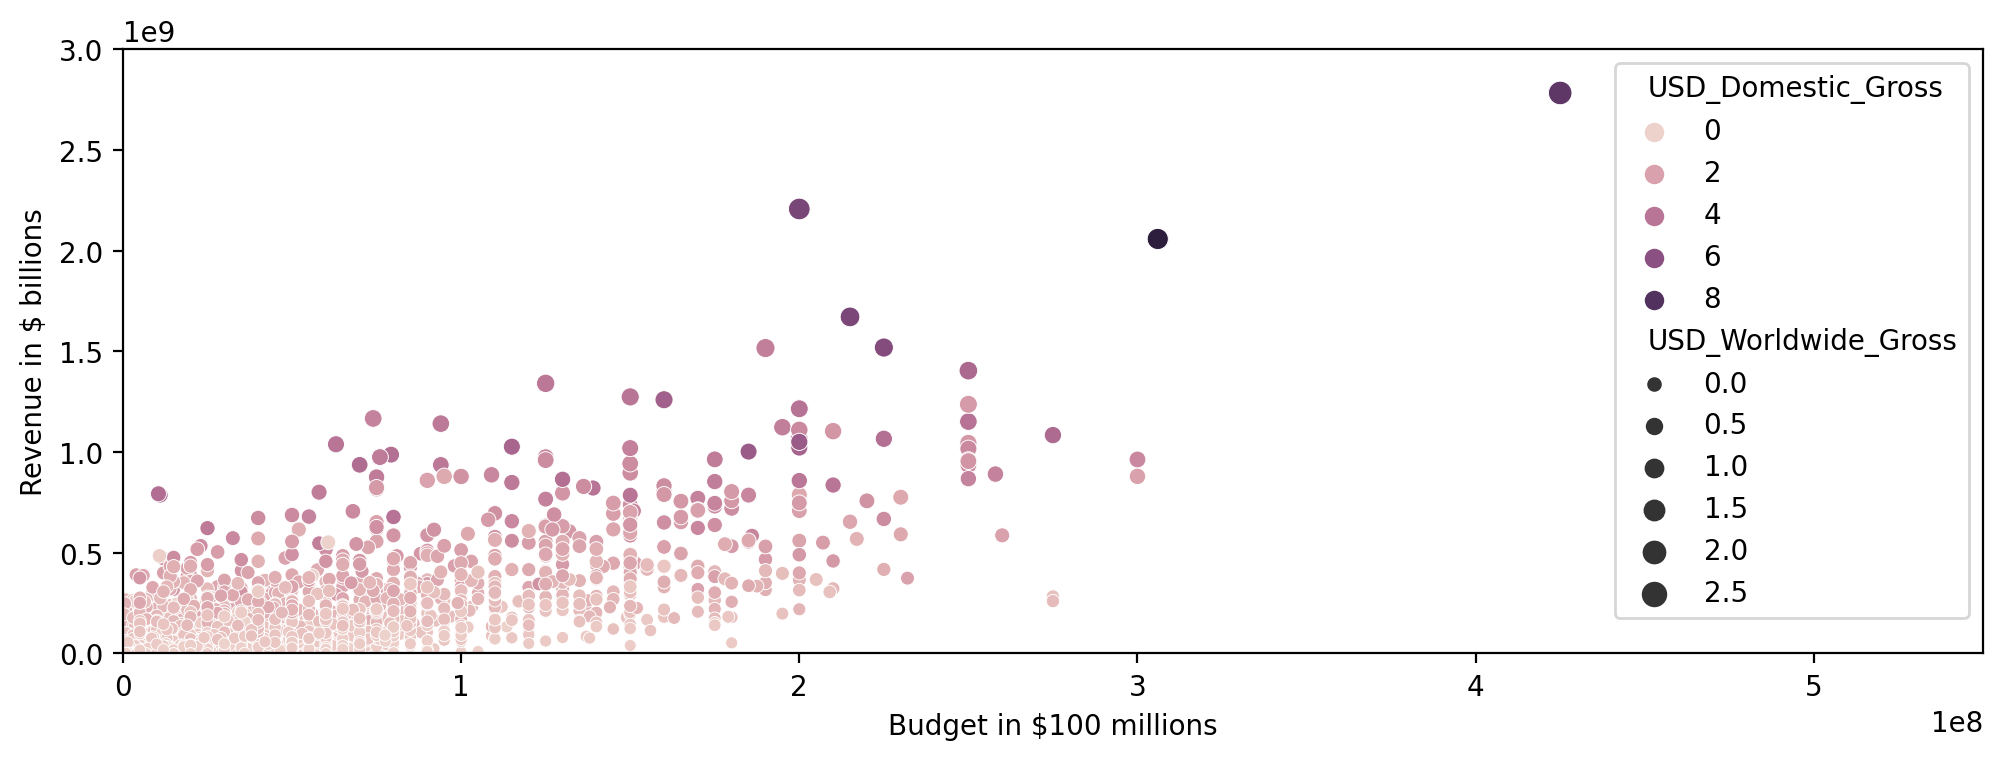

In [136]:
plt.figure(figsize=(12,4), dpi=200)

ax = sns.scatterplot(data=data_clean,
                     x='USD_Production_Budget',
                     y='USD_Worldwide_Gross',
                     hue='USD_Domestic_Gross',
                     size='USD_Worldwide_Gross')

ax.set(ylim=(0, 3_000_000_000), xlim=(0, 550_000_000),
       ylabel='Revenue in $ billions', xlabel='Budget in $100 millions')

### Plotting Movie Releases over Time

**Challenge**: Try to create the following Bubble Chart:

<img src=https://i.imgur.com/8fUn9T6.png>



[(0.0, 450000000.0),
 (-20089.0, 18262.0),
 Text(0, 0.5, 'Budget in $100 millions'),
 Text(0.5, 0, 'Year')]

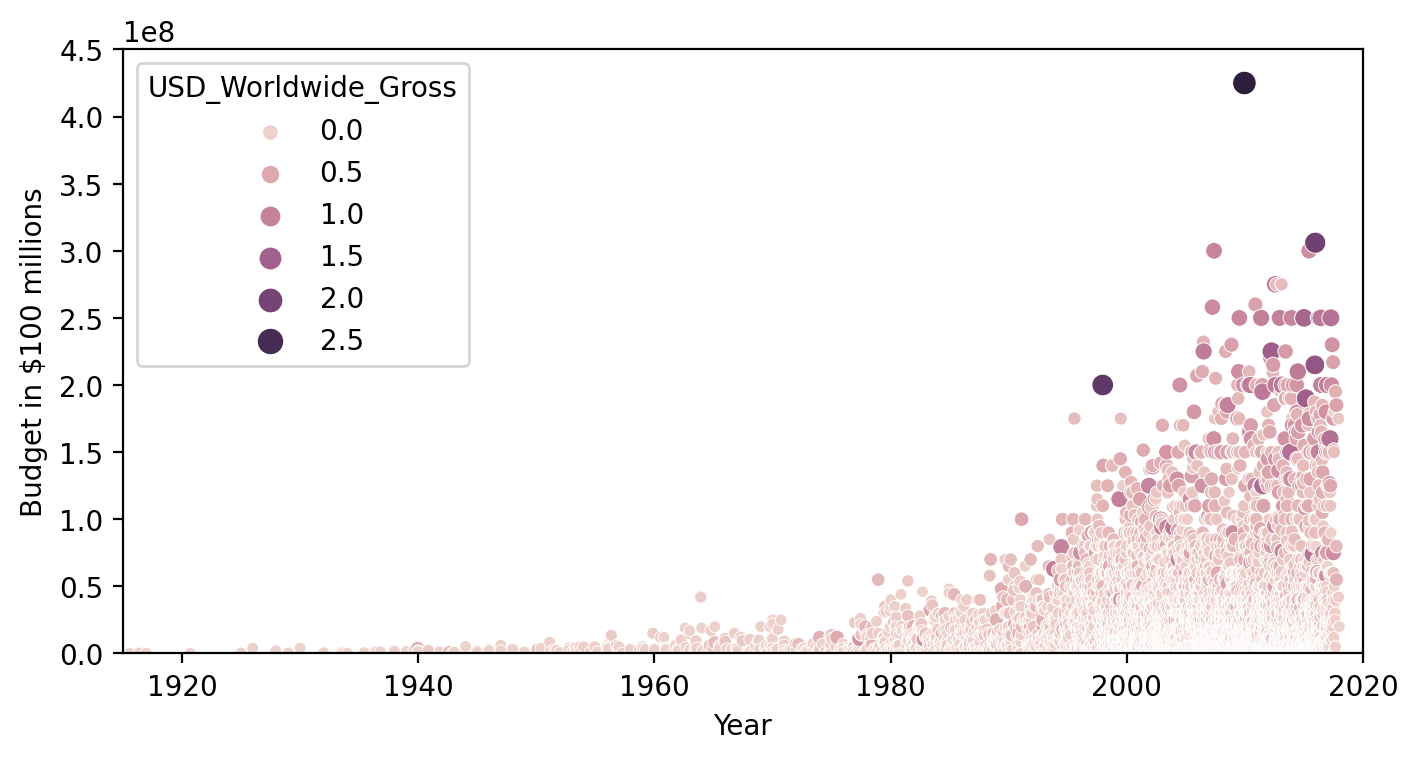

In [140]:
plt.figure(figsize=(8,4), dpi=200)

ax = sns.scatterplot(data=data_clean,
                     x='Release_Date',
                     y='USD_Production_Budget',
                     hue='USD_Worldwide_Gross',
                     size='USD_Worldwide_Gross')

ax.set(ylim=(0, 450_000_000), xlim=(pd.Timestamp('1915'), pd.Timestamp('2020')), ylabel='Budget in $100 millions', xlabel='Year')

# Converting Years to Decades Trick

**Challenge**: Create a column in `data_clean` that has the decade of the release. 

<img src=https://i.imgur.com/0VEfagw.png width=650> 

Here's how: 
1. Create a [`DatetimeIndex` object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) from the Release_Date column. 
2. Grab all the years from the `DatetimeIndex` object using the `.year` property.
<img src=https://i.imgur.com/5m06Ach.png width=650>
3. Use floor division `//` to convert the year data to the decades of the films.
4. Add the decades as a `Decade` column to the `data_clean` DataFrame.

In [148]:
years = [date.year for date in data_clean['Release_Date']]
years

[1915,
 1916,
 1916,
 1920,
 1925,
 1925,
 1927,
 1929,
 1930,
 1931,
 1933,
 1933,
 1933,
 1934,
 1935,
 1936,
 1936,
 1936,
 1937,
 1938,
 1938,
 1939,
 1939,
 1939,
 1940,
 1940,
 1940,
 1941,
 1942,
 1942,
 1943,
 1943,
 1944,
 1944,
 1945,
 1945,
 1945,
 1946,
 1946,
 1946,
 1946,
 1947,
 1948,
 1948,
 1949,
 1949,
 1950,
 1950,
 1951,
 1951,
 1951,
 1951,
 1951,
 1952,
 1952,
 1952,
 1953,
 1953,
 1953,
 1953,
 1953,
 1953,
 1954,
 1954,
 1954,
 1955,
 1955,
 1956,
 1956,
 1956,
 1956,
 1956,
 1956,
 1956,
 1956,
 1956,
 1956,
 1957,
 1957,
 1957,
 1958,
 1959,
 1959,
 1959,
 1959,
 1960,
 1960,
 1960,
 1960,
 1960,
 1961,
 1961,
 1961,
 1961,
 1961,
 1962,
 1962,
 1962,
 1962,
 1962,
 1962,
 1962,
 1963,
 1963,
 1963,
 1963,
 1963,
 1963,
 1963,
 1963,
 1964,
 1964,
 1964,
 1964,
 1964,
 1964,
 1964,
 1965,
 1965,
 1965,
 1965,
 1965,
 1965,
 1966,
 1966,
 1966,
 1966,
 1967,
 1967,
 1967,
 1967,
 1967,
 1967,
 1967,
 1968,
 1968,
 1968,
 1968,
 1968,
 1968,
 1968,
 1968,
 1968,

In [149]:
decades = [year//10*10 for year in years]
decades

[1910,
 1910,
 1910,
 1920,
 1920,
 1920,
 1920,
 1920,
 1930,
 1930,
 1930,
 1930,
 1930,
 1930,
 1930,
 1930,
 1930,
 1930,
 1930,
 1930,
 1930,
 1930,
 1930,
 1930,
 1940,
 1940,
 1940,
 1940,
 1940,
 1940,
 1940,
 1940,
 1940,
 1940,
 1940,
 1940,
 1940,
 1940,
 1940,
 1940,
 1940,
 1940,
 1940,
 1940,
 1940,
 1940,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1950,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,
 1960,

In [150]:
data_clean['Decade'] = decades

/Users/mymac/PycharmProjects/100DaysOfCode/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Separate the "old" (before 1969) and "New" (1970s onwards) Films

**Challenge**: Create two new DataFrames: `old_films` and `new_films`
* `old_films` should include all the films before 1969 (up to and including 1969)
* `new_films` should include all the films from 1970 onwards
* How many films were released prior to 1970?
* What was the most expensive film made prior to 1970?

In [153]:
old_films = data_clean.query('Decade < 1970')
new_films = data_clean.query('Decade >= 1970')

print(f'There were {len(old_films)} movies made before 1970 and {len(new_films)} made after.')

There were 153 movies made before 1970 and 5231 made after.


# Seaborn Regression Plots

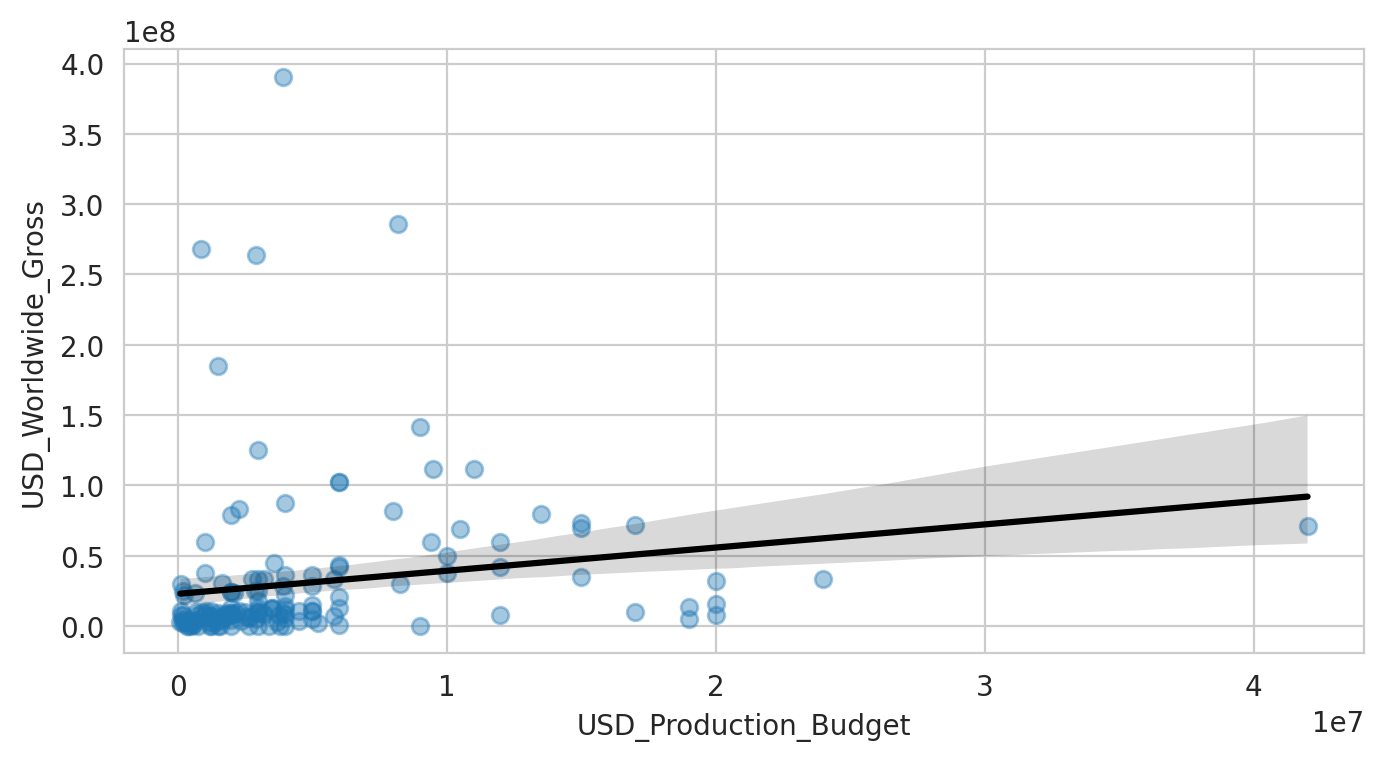

In [157]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style('whitegrid'):
    sns.regplot(data=old_films,
                x='USD_Production_Budget',
                y='USD_Worldwide_Gross',
                scatter_kws = {'alpha': 0.4},
                line_kws = {'color': 'black'}
                )

**Challenge**: Use Seaborn's `.regplot()` to show the scatter plot and linear regression line against the `new_films`. 
<br>
<br>
Style the chart

* Put the chart on a `'darkgrid'`.
* Set limits on the axes so that they don't show negative values.
* Label the axes on the plot "Revenue in \$ billions" and "Budget in \$ millions".
* Provide HEX colour codes for the plot and the regression line. Make the dots dark blue (#2f4b7c) and the line orange (#ff7c43).

Interpret the chart

* Do our data points for the new films align better or worse with the linear regression than for our older films?
* Roughly how much would a film with a budget of $150 million make according to the regression line?

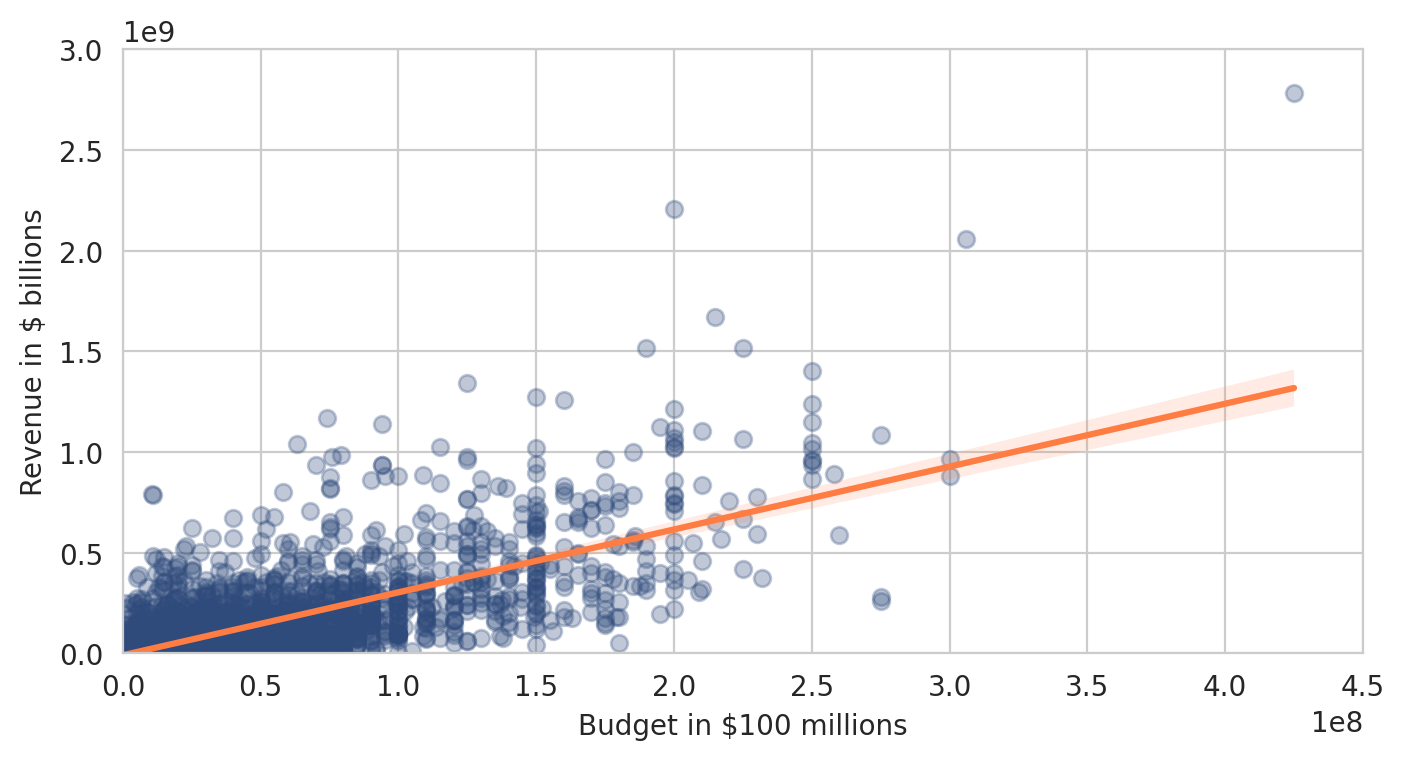

In [163]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style('whitegrid'):
    ax = sns.regplot(data=new_films,
                x='USD_Production_Budget',
                y='USD_Worldwide_Gross',
                color = '#2f4b7c',
                scatter_kws = {'alpha': 0.3},
                line_kws = {'color': '#ff7c43'}
                )
    ax.set(ylim=(0, 3_000_000_000), xlim=(0, 450_000_000),
           ylabel='Revenue in $ billions', xlabel='Budget in $100 millions')

In [164]:
print('Visually, it is difficult to say which line of regression has a better goodness of fit; however, the greater number of outliers in for the old_films data makes me thing there is a stronger association with budget and revenue following 1970. Post-1970, a film with a budget of $150M is expected to make $500M. Not too shabby!')

Visually, it is difficult to say which line of regression has a better goodness of fit; however, the greater number of outliers in for the old_films data makes me thing there is a stronger association with budget and revenue following 1970. Post-1970, a film with a budget of $150M is expected to make $500M. Not too shabby!


# Run Your Own Regression with scikit-learn

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

In [173]:
regression = LinearRegression()

X = pd.DataFrame(new_films, columns=['USD_Production_Budget'])
y = pd.DataFrame(new_films, columns=['USD_Worldwide_Gross'])

regression.fit(X, y)

print(regression.intercept_[0])
print(regression.coef_[0][0])

regression.score(X, y)

-8650768.006610274
3.1225959173210933


0.5577032617720403

**Challenge**: Run a linear regression for the `old_films`. Calculate the intercept, slope and r-squared. How much of the variance in movie revenue does the linear model explain in this case?

In [174]:
X = pd.DataFrame(old_films, columns=['USD_Production_Budget'])
y = pd.DataFrame(old_films, columns=['USD_Worldwide_Gross'])

regression.fit(X, y)

print(regression.intercept_[0])
print(regression.coef_[0][0])

regression.score(X, y)

22821538.635080386
1.6477131440107315


0.02937258620576877

In [ ]:
print('USD_Worldwide_Gross = $22,821,538.64 + $1.66*USD_Production_Budget')
print('The Coefficient of Determination is 0.029, meaning that less than 3% of the variation in the dependent variable can be attributed to variations in the independent variable. In other words, knowing the budget only improves our model predictions by ~3%.')

# Use Your Model to Make a Prediction

We just estimated the slope and intercept! Remember that our Linear Model has the following form:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

**Challenge**:  How much global revenue does our model estimate for a film with a budget of $350 million? 

In [181]:
pred = regression.intercept_[0] + regression.coef_[0][0]*350_000_000
print('$' + '{:,.2f}'.format(pred))

$599,521,139.04
